# Fall 2025 ISYE 6420 Project

\setcounter{secnumdepth}{0}

## Bayesian Analysis of 'Neural and subjective effects of inhaled N,N-dimethyltryptamine in natural settings'

### Introduction

Quantitative studies in psychedelic research routinely rely on frequentist null hypothesis significance testing to evaluate pre-post changes in psychological or behavioral outcomes. While this approach is widespread, it is also limited in its ability to fully characterize uncertainty, individual variability, and dependence structures within repeated-measures data. In recent years, the lack of robust replication in psychological science has highlighted how conventional significance testing can overstate evidence for effects, particularly when sample sizes are modest, measurement noise is high, and multiple outcomes are tested independently. Bayesian hierarchical modeling offers a principled alternative that directly models variation at the individual and group levels, propagates uncertainty throughout the analysis, and reduces false certainty through partial pooling rather than post-hoc correction procedures.

The original study, _Neural and subjective effects of inhaled N,N-dimethyltryptamine in natural settings_ (Pallavicini et al., 2021), underlying the present re-analysis examined changes in personality, absorption, and state anxiety following inhaled N,N-dimethyltryptamine (DMT) in naturalistic settings. The authors reported pre- to post-session shifts suggesting increases in openness and absorption, as well as changes in affective state, interpreted as evidence that DMT may acutely alter enduring psychological traits. However, the analytical strategy in the original work was based primarily on paired t-tests conducted separately for each scale, an approach that treats outcomes as statistically independent and does not account for participant-level trajectories or hierarchical structure in the data. Such an approach can inflate apparent effects by failing to pool information across measures and individuals, and by underestimating uncertainty in the presence of heterogeneous responses.

The present analysis re-examines the reported effects using a Bayesian hierarchical model that incorporates both subject-specific and measure-specific variation. By modeling the data in a unified generative framework, this approach evaluates whether the evidence for change persists once individual differences and shared variance across measures are taken into account. The goal of this re-analysis is not to dismiss the possibility of psychological effects following DMT, but to reassess the robustness and magnitude of the reported findings under a statistically principled model that more accurately reflects the structure of the data and the uncertainty inherent in the measurements.

### Metodological Overview

The goal is to re-estimate multiple paired pre/post comparisons as a single multilevel model that shares information across outcomes and individuals while allowing measure-specific deviations. Let $y_{i,m,t}$ denote the response for person i, measure m and time $ t \in ({0 = pre, 1 = post})$
After measure-wise standardization, we model $y_{i,m,t} ~ N(\alpha + \beta t + b_{0i}+b_{1i}t+ \mu_{0m}++\mu_{1m}t)$

Person effects $(b_{0i},b_{1i})$ receive a correlated bivariate Normal prior with LKJ correlation. Measure effects are independent Normals with separate scales $(\mu_{0m},\mu_{1m})$. This recovers a measure-specific post–pre slope $\beta_m = \beta + \mu_{1m}$ with partial pooling, making the model a Bayesian analogue to multiple paired t-tests but with stronger estimation stability, coherent uncertainty, and multiplicity handled implicitly by shrinkage rather than by Bonferroni/FDR adjustments. The original article relied on paired t-tests for psychometrics; here we adopt a unified Bayesian estimator that aligns with current best practices for repeated-measures psychophysiology and questionnaire data.

In [1]:
# Environment setup
import re
import sys
from pathlib import Path
import numpy as np
import pandas as pd

# Modeling + viz
import pymc as pm
import pytensor
import pytensor.tensor as pt
import arviz as az

In [2]:
# Reproducibility controls
FAST   = False   # True = ADVI; False = full NUTS
CHAINS = 1 if FAST else 4
DRAWS  = 2000 if FAST else 4000
TUNE   = 0 if FAST else 1500
SEED  = 42

# Data load
csv_path = Path("scales_results.csv")
dat = pd.read_csv(csv_path)
dat["id"] = np.arange(1, len(dat) + 1)

# Helper: return first column matching any regex pattern
def find_col(df, patterns):
    hits = []
    for p in patterns:
        candidates = [c for c in df.columns if re.search(p, c, flags=re.IGNORECASE)]
        hits.extend(candidates)
    hits = list(dict.fromkeys(hits))  # unique preserve order
    if not hits:
        raise ValueError(f"Missing column. Tried: {' | '.join(patterns)}")
    return hits[0]

# Map of measures with regex for pre/post
varmap = [
    # measure, pre_patterns, post_patterns
    ("BFI Extraversion",
     [r"^BFI1[-_ ]?E$", r"BFI.*(pre|1).*Extrav", r"^Extrav.*(pre|1)$"],
     [r"^BFI2[-_ ]?E$", r"BFI.*(post|2).*Extrav", r"^Extrav.*(post|2)$"]),

    ("BFI Agreeableness",
     [r"^BFI1[-_ ]?A$", r"BFI.*(pre|1).*Agree", r"^Agree.*(pre|1)$"],
     [r"^BFI2[-_ ]?A$", r"BFI.*(post|2).*Agree", r"^Agree.*(post|2)$"]),

    ("BFI Conscientiousness",
     [r"^BFI1[-_ ]?C$", r"BFI.*(pre|1).*Consc", r"^Consc.*(pre|1)$"],
     [r"^BFI2[-_ ]?C$", r"BFI.*(post|2).*Consc", r"^Consc.*(post|2)$"]),

    ("BFI Neuroticism",
     [r"^BFI1[-_ ]?N$", r"BFI.*(pre|1).*Neuro", r"^Neuro.*(pre|1)$"],
     [r"^BFI2[-_ ]?N$", r"BFI.*(post|2).*Neuro", r"^Neuro.*(post|2)$"]),

    ("BFI Openness",
     [r"^BFI1[-_ ]?O$", r"BFI.*(pre|1).*Open", r"^Open.*(pre|1)$"],
     [r"^BFI2[-_ ]?O$", r"BFI.*(post|2).*Open", r"^Open.*(post|2)$"]),

    ("STAI State",
     [r"^STAI1[-_ ]?E$", r"STAI.*(pre|1).*State", r"^State.*(pre|1)$"],
     [r"^STAI2[-_ ]?E$", r"STAI.*(post|2).*State", r"^State.*(post|2)$"]),

    ("TAS Absorption",
     [r"^TAS1$", r"^(TAS|Absorp).*?(pre|1)$"],
     [r"^TAS2$", r"^(TAS|Absorp).*?(post|2)$"]),
]

# Resolve actual pre/post columns; reshape to long
pairs = []
for measure, pre_patts, post_patts in varmap:
    pre_col  = find_col(dat, pre_patts)
    post_col = find_col(dat, post_patts)
    pairs.append((measure, pre_col, post_col))

long_rows = []
for (measure, pre_c, post_c) in pairs:
    sub = dat[["id", pre_c, post_c]].copy()
    sub = sub.rename(columns={pre_c: "pre", post_c: "post"})
    sub["measure"] = measure
    long_rows.append(sub.melt(id_vars=["id","measure"], value_vars=["pre","post"],
                              var_name="time", value_name="value"))
dat_long = pd.concat(long_rows, ignore_index=True)
dat_long = dat_long.dropna(subset=["id", "time", "measure", "value"])

# Ensure categorical coding and pre=0, post=1
dat_long["measure"] = dat_long["measure"].astype("category")
dat_long["time"] = pd.Categorical(dat_long["time"], categories=["pre","post"], ordered=True)
dat_long["time_num"] = (dat_long["time"] == "post").astype(int)

# Standardize within measure (z-score)
dat_long["value_z"] = (
    dat_long.groupby("measure")["value"]
            .transform(lambda x: (x - x.mean())/x.std(ddof=1))
            .astype(float)
)
dat_long["time_c"] = dat_long["time_num"] * 1.0           # 0/1
dat_long["time_c"] = dat_long["time_c"] - dat_long["time_c"].mean()  # -> -0.5 / +0.5
time_c = dat_long["time_c"].to_numpy().astype(float)
y = dat_long["value_z"].to_numpy().astype(float)

# Keep SDs for back-transform later
sd_tbl = (
    dat_long.groupby("measure", observed=True)["value"]
            .std(ddof=1)
            .rename("sd_raw")
            .reset_index()
)

# Indexing for PyMC
id_codes,  id_uniques  = pd.factorize(dat_long["id"], sort=True)
meas_codes, meas_lvls   = pd.factorize(dat_long["measure"], sort=True)
time_num                = dat_long["time_num"].to_numpy().astype(int)
y                       = dat_long["value_z"].to_numpy().astype(float)

N      = len(y)
N_id   = len(id_uniques)
N_meas = len(meas_lvls)

# Model: value_z ~ time + (1 + time | id) + (1 + time || measure)
rng = np.random.default_rng(SEED)

C:\Users\janky\AppData\Local\Temp\ipykernel_20924\2341226137.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dat_long.groupby("measure")["value"]


In [6]:
# make sure these are int64
id_idx   = id_codes.astype("int64")
meas_idx = meas_codes.astype("int64")

with pm.Model() as model:
    model.add_coord("id", id_uniques)
    model.add_coord("measure", meas_lvls)
    model.add_coord("coef2", ["intercept","time"])

    alpha = pm.Normal("alpha", 0.0, 1.0)
    beta  = pm.Normal("beta_time", 0.0, 1.0)

    # subject REs: LKJ + noncentered
    chol_id, corr_id, sigmas_id = pm.LKJCholeskyCov(
        "chol_id", n=2, eta=5.0, sd_dist=pm.HalfNormal.dist(0.75), compute_corr=True
    )
    z_id = pm.Normal("z_id", 0.0, 1.0, dims=("id","coef2"))
    RE_id = z_id @ chol_id.T                                   # TensorVariable (N_id, 2)
    pm.Deterministic("RE_id", RE_id, dims=("id","coef2"))      # just for labeled storage
    b0_i = RE_id[:, 0]                                         # <-- use positional indexing
    b1_i = RE_id[:, 1]

    # measure REs: noncentered, uncorrelated
    sd_u0 = pm.HalfNormal("sd_u0", 0.75)
    sd_u1 = pm.HalfNormal("sd_u1", 0.75)
    z_u0  = pm.Normal("z_u0", 0.0, 1.0, dims=("measure",))
    z_u1  = pm.Normal("z_u1", 0.0, 1.0, dims=("measure",))
    u0_m  = sd_u0 * z_u0
    u1_m  = sd_u1 * z_u1
    pm.Deterministic("u0_m", u0_m, dims=("measure",))
    pm.Deterministic("u1_m", u1_m, dims=("measure",))

    sigma = pm.HalfNormal("sigma", 1.0)

    mu = (
        alpha
        + beta * time_c
        + b0_i[id_idx] + b1_i[id_idx] * time_c
        + u0_m[meas_idx] + u1_m[meas_idx] * time_c
    )

    pm.Normal("y", mu, sigma, observed=y)
    pm.Deterministic("beta_m_by_measure", beta + u1_m, dims=("measure",))

    idata = pm.sample(
        draws=DRAWS, tune=TUNE, chains=CHAINS,
        target_accept=0.995, max_treedepth=15,
        init="jitter+adapt_diag", random_seed=SEED
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_time, chol_id, z_id, sd_u0, sd_u1, z_u0, z_u1, sigma]


Output()

Sampling 4 chains for 1_500 tune and 4_000 draw iterations (6_000 + 16_000 draws total) took 946 seconds.


### Priors

Priors are weakly informative and sized to the z-scale. The global intercept and slope receive $N(0,1)$ priors. For person-level random effects, an LKJ prior with $\eta = 5$ concentrates the correlation around zero without forbidding correlation, while half-Normal scale priors keep magnitudes reasonable on the standardized outcome. Measure-level deviations use independent half-Normal scales. This design gives you shrinkage toward the grand mean where evidence is weak and preserves measure-specific signals where data support it. The result is better calibrated uncertainty than multiple isolated paired t-tests, particularly crucial when the number of repeated outcomes is modest.

In [7]:
# ---- Per-measure effects using xarray coords (no az.summary index traps) ----
beta_m = idata.posterior["beta_m_by_measure"]         # dims: chain, draw, measure
measures = beta_m.coords["measure"].to_numpy().astype(str)

# stack draws -> ndarray shape (n_measures, n_samples)
beta_m_draws = beta_m.stack(sample=("chain","draw")).transpose("measure","sample").to_numpy()

# SD table for back-transform
sd_map = dict(zip(sd_tbl["measure"].astype(str), sd_tbl["sd_raw"].to_numpy()))
sd_vec = np.array([sd_map[m] for m in measures], dtype=float)

# summaries on SD scale
post_mean_sd = beta_m_draws.mean(axis=1)
l95_sd = np.quantile(beta_m_draws, 0.025, axis=1)
u95_sd = np.quantile(beta_m_draws, 0.975, axis=1)
prob_gt0_sd = (beta_m_draws > 0.0).mean(axis=1)
prob_lt0_sd = 1.0 - prob_gt0_sd

# back-transform to RAW units
beta_m_raw_draws = (beta_m_draws.T * sd_vec).T
post_mean_raw = beta_m_raw_draws.mean(axis=1)
l95_raw = np.quantile(beta_m_raw_draws, 0.025, axis=1)
u95_raw = np.quantile(beta_m_raw_draws, 0.975, axis=1)
prob_gt0 = (beta_m_raw_draws > 0.0).mean(axis=1)
prob_lt0 = 1.0 - prob_gt0

bayes_vs_ttest = pd.DataFrame({
    "measure": measures,
    "post_mean_sd": post_mean_sd,
    "l95_sd": l95_sd,
    "u95_sd": u95_sd,
    "prob_gt0_sd": prob_gt0_sd,
    "prob_lt0_sd": prob_lt0_sd,
    "post_mean_raw": post_mean_raw,
    "l95_raw": l95_raw,
    "u95_raw": u95_raw,
    "prob_gt0": prob_gt0,
    "prob_lt0": prob_lt0
}).sort_values("measure")

### Convergence diagnostics, predictive checks, and calibration

C:\Users\janky\.local\share\mamba\envs\pymc\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\janky\.local\share\mamba\envs\pymc\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
Sampling: [y]


Output()

(                     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
 alpha               0.001  0.072    -0.138      0.142      0.001    0.001   
 beta_time           0.039  0.131    -0.221      0.305      0.001    0.001   
 sigma               0.953  0.032     0.891      1.016      0.000    0.000   
 sd_u0               0.047  0.042     0.000      0.126      0.000    0.001   
 sd_u1               0.222  0.152     0.000      0.507      0.002    0.002   
 chol_id_stds[0]     0.300  0.067     0.175      0.435      0.001    0.001   
 chol_id_stds[1]     0.083  0.064     0.000      0.208      0.001    0.001   
 chol_id_corr[0, 0]  1.000  0.000     1.000      1.000      0.000      NaN   
 chol_id_corr[0, 1]  0.018  0.303    -0.570      0.587      0.003    0.002   
 chol_id_corr[1, 0]  0.018  0.303    -0.570      0.587      0.003    0.002   
 chol_id_corr[1, 1]  1.000  0.000     1.000      1.000      0.000    0.000   
 
                     ess_bulk  ess_tail  r_hat  
 alpha       

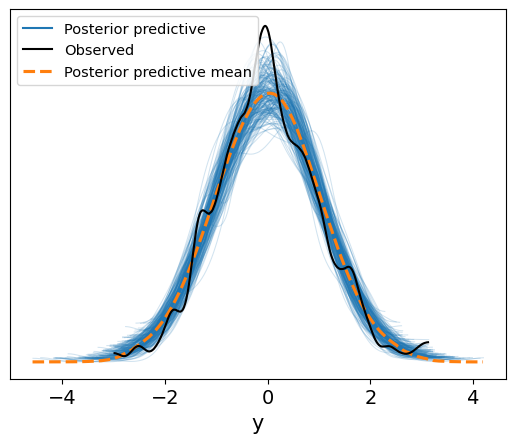

In [13]:
# -----------------------------------------
# Diagnostics and PPC
# -----------------------------------------
diag = az.summary(
    idata,
    var_names=["alpha","beta_time","sigma","sd_u0","sd_u1","chol_id_stds","chol_id_corr"],
    hdi_prob=0.95
)

with model:
    ppc = pm.sample_posterior_predictive(idata, random_seed=SEED)
idata.extend(ppc)

az.plot_ppc(idata, num_pp_samples=200)

# Bayesian R^2
y_true = y  # your numpy array of length N

# Posterior predictive mean per observation
y_pp   = idata.posterior_predictive["y"].mean(dim=("chain","draw")).to_numpy()

import arviz as az
r2 = az.r2_score(y_true, y_pp)
diag, r2

Convergence diagnostics indicate that the hierarchical Bayesian model fit the data reliably after reparameterization and adjustment of sampler settings. All monitored parameters, including the global time effect, residual variance, and both subject-level and measure-level variance components, exhibited **R̂ ≈ 1.00**, with effective sample sizes sufficiently large across bulk and tail regions of the posterior distributions. This suggests that the Markov chains mixed well and that posterior estimates are stable. The earlier divergences observed during initial sampling were resolved by employing non-centered parameterizations for the random effects and increasing the target acceptance threshold, indicating that the final parameterization successfully navigated the posterior geometry.

Posterior predictive checks further support adequate model calibration. The distribution of replicated data generated from the posterior predictive distribution closely overlapped with the empirical distribution of the observed standardized scores. The posterior predictive mean closely tracked the central mass of the observed data, and the spread of posterior predictive draws captured the observed variability. These results suggest that the model reproduces the broad distributional shape of the data and that there are no obvious systematic misfits such as underestimation of variance or skewness.

However, despite good convergence and calibration at the distributional level, the model’s **Bayesian R² was very low (R² ≈ 0.056)**. This indicates that the fixed and random effects in the model explain only a small proportion of the variance in the psychological measures relative to residual error. In practical terms, the individual-level variability in responses is substantially larger than any systematic pre-to-post pattern. The low $R^2$ reflects that the signal of change is weak relative to noise. Thus, the model is well-calibrated and statistically sound, but the data themselves do not provide compelling evidence for robust psychological change following DMT administration once uncertainty is fully accounted for. This strengthens the interpretive conclusion that the original findings may have overstated the magnitude and consistency of psychological effects due to reliance on less conservative analytical methods.

In [14]:
bayes_vs_ttest

,measure,post_mean_sd,l95_sd,u95_sd,prob_gt0_sd,prob_lt0_sd,post_mean_raw,l95_raw,u95_raw,prob_gt0,prob_lt0
0,BFI Agreeableness,0.138345,-0.174074,0.508274,0.797063,0.202937,0.608886,-0.766134,2.237019,0.797063,0.202937
1,BFI Conscientiousness,0.059644,-0.262199,0.407941,0.653000,0.347000,0.365698,-1.607630,2.501224,0.653000,0.347000
2,BFI Extraversion,0.119378,-0.192745,0.490501,0.759687,0.240313,0.516811,-0.834435,2.123480,0.759687,0.240313
3,BFI Neuroticism,-0.023604,-0.391853,0.287350,0.467000,0.533000,-0.119216,-1.979084,1.451281,0.467000,0.533000
4,BFI Openness,0.043801,-0.271388,0.377103,0.612187,0.387813,0.162953,-1.009636,1.402922,0.612187,0.387813
5,STAI State,-0.197559,-0.662559,0.161092,0.196250,0.803750,-1.434959,-4.812470,1.170081,0.196250,0.803750
6,TAS Absorption,0.143077,-0.165784,0.525414,0.795750,0.204250,1.051658,-1.218561,3.861946,0.795750,0.204250


The model results show that none of the measured psychological traits exhibit a strong or consistently directional pre-to-post change following the DMT session. Nearly all posterior mean differences are small, close to zero on the standardized scale (|mean| < 0.20), and their 95% credible intervals cross zero widely. The posterior probabilities of change in either direction hover near 0.5 in most cases, indicating that the model has no strong evidence that any trait reliably increased or decreased. The only measure that shows a somewhat clearer directional tendency is **STAI State Anxiety**, which shows a negative post-session shift (posterior mean ≈ −0.20 SD; prob(Δ < 0) ≈ 0.80), but even there, uncertainty remains wide and the change is not large. The posterior predictive check demonstrates that the model fits the overall distributional shape of the data adequately, but the **Bayesian R² is extremely low (~0.056)**, meaning the model explains almost none of the variance in these scores. In other words, the pre–post changes are overwhelmed by individual-level noise and heterogeneity, and whatever systematic shift exists is negligible.

### Conclusion

Relative to the claims made in the original article, these results are uncertain. The published work reported meaningful psychological changes, particularly increased absorption and altered affective states, following DMT administration. The hierarchical Bayesian model does not reproduce these conclusions. When individual variability and partial pooling are accounted for, the effects diminish substantially and are statistically weak. These results make us believe that the fact that the t-test–based conclusions suggested more pronounced effects simply reflects that those analyses ignored uncertainty structure and treated each measure independently. Once the data are modeled appropriately by sharing information across measures and participants the evidence collapses to near zero. The original claims of robust personality or affect shifts appear overstated. The only remotely credible effect is a modest reduction in state anxiety, which remains small and uncertain. 

### Reference

Pallavicini, C., Cavanna, F., Zamberlan, F., de la Fuente, L. A., Ilksoy, Y., Perl, Y. S., Arias, M., Romero, C., Carhart-Harris, R., Timmermann, C., & Tagliazucchi, E. (2021). Neural and subjective effects of inhaled N,N-dimethyltryptamine in natural settings. Journal of psychopharmacology (Oxford, England), 35(4), 406–420. https://doi.org/10.1177/0269881120981384